### Who are the poor?

Attempt to replicate excellent chart by Matt Bruenig

----

Source: CPS ASEC

In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [2]:
# Extract person records for selected variables
variables = ['H_SEQ', 'PPPOS', 
             'PRECORD', 'A_AGE', 'MARSUPWT', 'PERLIS', 
             'SPM_Resources', 'SPM_PovThreshold', 'WKSWORK',
             'PRDISFLG', 'RSNNOTW', 'PYRSN', 'LKWEEKS',
             'SPM_Weight', 'SPM_ID', 'SPM_CapWkCCXpns',
             'SPM_Totval', 'SPM_MedXpns', 'SPM_ChildSupPd',
             'SPM_Poor', 'CTC_CRD', 'ACTC_CRD', 
             'SPM_NumKids', 'SPM_NumPer']

benefits = ['SS_VAL', 'SSI_VAL', 'UC_VAL', 'VET_VAL', 
            'WC_VAL', 'PAW_VAL']

path = '/home/brian/Documents/ASEC/'

dictfile = f'{path}/data/persfmt.txt'
dd = open(dictfile).read()
p = f'({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s'
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/data/asec2019_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=cols.keys())
        .query('PRECORD == 3'))

In [3]:
# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Student', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['SPM_Resources'] < df['SPM_PovThreshold'], 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['SPM_Totval'] - 
                       df[['SPM_CapWkCCXpns','SPM_MedXpns', 'SPM_ChildSupPd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['SPM_ID']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['SPM_PovThreshold'], 1, 0)

df['CTC'] = df[['CTC_CRD', 'ACTC_CRD']].sum(axis=1).groupby(df['SPM_ID']).transform('sum')
df['CALLOW'] = df['SPM_NumKids'] * 3300

df['CA_INC'] = df['SPM_Resources'] - df['CTC'] + df['CALLOW']

df['SPM_CA'] = np.where(df['CA_INC'] < df['SPM_PovThreshold'], 1, 0)

df['MI_GAP'] = ((df['SPM_PovThreshold'] - df['MARKET_INCOME']) / df['SPM_NumPer']) * df['SPM_Weight'] / 100
df['SPM_GAP'] = ((df['SPM_PovThreshold'] - df['SPM_Resources']) / df['SPM_NumPer']) * df['SPM_Weight'] / 100
df['CA_GAP'] = ((df['SPM_PovThreshold'] - df['CA_INC']) / df['SPM_NumPer']) * df['SPM_Weight'] / 100

In [4]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')
data4 = df.query('SPM_CA == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').SPM_Weight.sum() / 
                  data.SPM_Weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)


results['SPM_MI'] = (data3.groupby('Category').SPM_Weight.sum() / 
                  data3.SPM_Weight.sum() * 100).sort_values(ascending=False)

results.to_csv(data_dir / 'poor.csv', index_label='name')

results['SPM_CA'] = (data4.groupby('Category').SPM_Weight.sum() / 
                  data4.SPM_Weight.sum() * 100).sort_values(ascending=False)


print(results)

                      SPM        OPM     SPM_MI     SPM_CA
Category                                                  
Children        23.935014  32.022004  21.567392  16.495507
Elderly         17.859979  13.313400  33.406293  21.422614
Fully Employed  15.942622   9.827651  11.044724  16.120245
Disabled        13.713975  15.609597  13.612266  15.414322
Carers           7.432734   8.254535   5.135020   7.156848
Student          6.251977   6.206497   3.809745   7.167928
All Other        5.947823   5.878308   4.195099   6.286066
Unemployed       5.438619   5.699014   3.761860   5.788919
Early Retired    3.477258   3.188996   3.467599   4.147552


In [5]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]

results2.to_csv(data_dir / 'poor2.csv', index_label='name')

results2['SPM_CA'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_CA'], weights=x['SPM_Weight']))
                     * 100).loc[results.index]

print(results2)

                      SPM        OPM     SPM_MI     SPM_CA
Category                                                  
Children        13.420792  16.773802  22.909574   7.555149
Elderly         13.506284   9.748823  47.858398  13.233061
Fully Employed   5.346813   3.108906   7.017220   4.416109
Disabled        27.272641  28.850774  51.282502  25.039242
Carers          24.596071  26.063815  32.190979  19.345137
Student         29.753568  26.014633  34.347294  27.864305
All Other       14.977139  13.656449  20.011887  12.929529
Unemployed      21.936629  20.970621  28.744774  19.072677
Early Retired   23.043398  20.329840  43.532487  22.450934


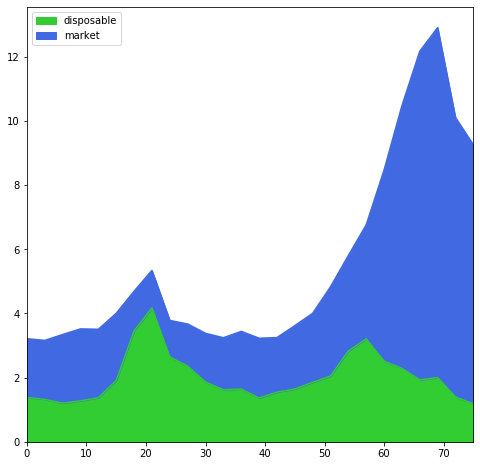

In [6]:
results3 = pd.DataFrame()

results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']

results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_latest.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue'])

In [7]:
np.average(df['SPM'], weights=df['MARSUPWT'])

0.12733621691005473

In [8]:
df.query('SPM == 1').MARSUPWT.sum()

4130224576

In [9]:
df.query('SPM == 1').SPM_GAP.sum()

169989957925.51

In [10]:
np.average(df['SPM_MI'], weights=df['MARSUPWT'])

0.24026174356801341

In [11]:
df.query('SPM_MI == 1').MARSUPWT.sum() 

7793029996

In [12]:
df.query('SPM_MI == 1').MI_GAP.sum()

511734906025.58

In [13]:
df.query('SPM_MI == 1').MARSUPWT.sum() - df.query('SPM == 1').MARSUPWT.sum()

3662805420

In [14]:
spm = pd.read_stata(f'{path}/data/spmresearch2014.dta')

In [15]:
dictfile = f'{path}/data/asec2015early_pubuse.dd.txt'
dd = open(dictfile, encoding='iso-8859-1').read()
p = re.compile(f'D ({"|".join(variables + benefits)})\s+(\d+)\s+(\d+)\s+')
cols = {name: (int(start) - 1, int(start) - 1 + int(length)) 
        for name, length, start in re.findall(p, dd)}

datafile = f'{path}/data/asec2015_pubuse.dat'
df = (pd.read_fwf(datafile, 
                  colspecs=list(cols.values()), 
                  header=None, 
                  names=cols.keys())
        .query('PRECORD == 3').astype('int'))

In [16]:
df = pd.merge(spm, df, left_on=['h_seq', 'pppos'], right_on=['H_SEQ', 'PPPOS'])#.keys()

In [17]:
# Categorize population
df['Category'] = (np.where(df.A_AGE < 18, 'Children', 
                  np.where(df.A_AGE > 64, 'Elderly', 
                  np.where(((df.PRDISFLG == 1) | (df.PYRSN == 1) | (df.RSNNOTW == 1)), 'Disabled', 
                  np.where(((df.PYRSN == 3) | (df.RSNNOTW == 4)), 'Student', 
                  np.where(((df.PYRSN == 2) | (df.RSNNOTW == 3)), 'Carers',
                  np.where(((df.PYRSN == 5) | (df.RSNNOTW == 5) | (df.LKWEEKS > 0)), 'Unemployed',         
                  np.where(((df.PYRSN == 4) | (df.RSNNOTW == 2)), 'Early Retired',  
                  np.where(df.WKSWORK > 49, 'Fully Employed', 'All Other')))))))))

df['AGE_GRP'] = pd.cut(df.A_AGE, range(0, 79, 3))

df['SPM'] = np.where(df['spmu_poor'] == 1, 1, 0)
df['OPM'] = np.where(df['PERLIS'] == 1, 1, 0)
df['MARKET_INCOME'] = (df['spmu_totval'] - 
                       df[['spmu_capwknchcarexpns','spmu_medoopnmcareb', 'spmu_childsuppd']].sum(axis=1) - 
                       df[benefits].sum(axis=1).groupby(df['spmu_id']).transform('sum'))

df['SPM_MI'] = np.where(df['MARKET_INCOME'] < df['spmu_povthreshold'], 1, 0)

df['CTC'] = df[['CTC_CRD', 'ACTC_CRD']].sum(axis=1).groupby(df['spmu_id']).transform('sum')
df['CALLOW'] = df['spmu_numkids'] * 3300

df['CA_INC'] = df['spmu_resources'] - df['CTC'] + df['CALLOW']

df['SPM_CA'] = np.where(df['CA_INC'] < df['spmu_povthreshold'], 1, 0)

df['MI_GAP'] = ((df['spmu_povthreshold'] - df['MARKET_INCOME']) / df['spmu_numper']) * df['spmu_weight'] / 100
df['SPM_GAP'] = ((df['spmu_povthreshold'] - df['spmu_resources']) / df['spmu_numper']) * df['spmu_weight'] / 100
df['CA_GAP'] = ((df['spmu_povthreshold'] - df['CA_INC']) / df['spmu_numper']) * df['spmu_weight'] / 100

In [18]:
# Only below poverty line
data = df.query('SPM == 1')
data2 = df.query('OPM == 1')
data3 = df.query('SPM_MI == 1')
data4 = df.query('SPM_CA == 1')

results = pd.DataFrame()

# Group share of total
results['SPM'] = (data.groupby('Category').spmu_weight.sum() / 
                  data.spmu_weight.sum() * 100).sort_values(ascending=False)

results['OPM'] = (data2.groupby('Category').MARSUPWT.sum() / 
                  data2.MARSUPWT.sum() * 100).sort_values(ascending=False)


#results.to_csv(data_dir / 'poor.csv', index_label='name')


results['SPM_MI'] = (data3.groupby('Category').spmu_weight.sum() / 
                  data3.spmu_weight.sum() * 100).sort_values(ascending=False)

results['SPM_CA'] = (data4.groupby('Category').spmu_weight.sum() / 
                  data4.spmu_weight.sum() * 100).sort_values(ascending=False)


print(results)

                      SPM        OPM     SPM_MI     SPM_CA
Category                                                  
Children        25.924970  33.823404  24.266931  17.333621
Fully Employed  16.304491  10.080446  11.606246  16.586023
Elderly         13.769305   9.761345  27.532471  17.230063
Disabled        12.904645  14.852713  13.947804  14.804994
Carers           8.679352   9.720166   6.423687   8.290956
Unemployed       8.291804   8.243360   6.044157   9.077884
Student          8.158302   7.904065   5.153203   9.368350
Early Retired    3.382392   3.065769   3.394216   4.231026
All Other        2.584739   2.548731   1.631286   3.077083


In [19]:
results2 = pd.DataFrame()

# Poverty rate of each group
results2['SPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM'], weights=x['spmu_weight']))
                     * 100).loc[results.index]
results2['OPM'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['OPM'], weights=x['MARSUPWT']))
                     * 100).loc[results.index]

#results2.to_csv(data_dir / 'poor2.csv', index_label='name')

results2['SPM_MI'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_MI'], weights=x['spmu_weight']))
                     * 100).loc[results.index]

results2['SPM_CA'] = (df.groupby('Category')
                     .apply(lambda x: np.average(x['SPM_CA'], weights=x['spmu_weight']))
                     * 100).loc[results.index]

print(results2)

                      SPM        OPM     SPM_MI     SPM_CA
Category                                                  
Children        16.987500  21.515458  28.250489   8.826853
Fully Employed   6.994778   4.137612   8.846232   5.529863
Elderly         14.425015   9.979379  51.244745  14.028025
Disabled        28.174830  30.672190  54.102955  25.120538
Carers          26.036791  28.098275  34.236115  19.329037
Unemployed      27.551753  25.401457  35.680903  23.441763
Student         28.323841  24.777499  31.785531  25.276730
Early Retired   23.477962  20.596569  41.857744  22.823775
All Other       23.874094  22.185618  26.769496  22.087922


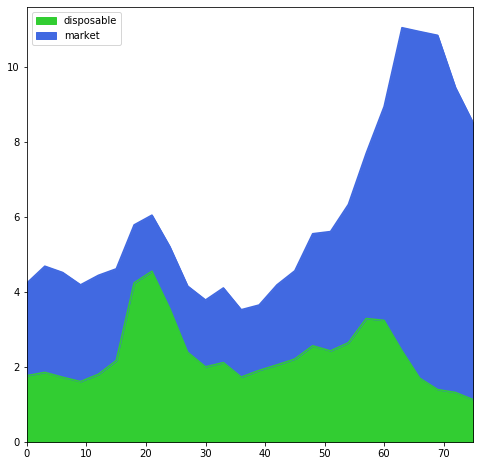

In [20]:
results3 = pd.DataFrame()

#results3['ca_gap'] = (data4.groupby('AGE_GRP')['CA_GAP'].sum() / 3e9)
results3['disposable'] = (data.groupby('AGE_GRP')['SPM_GAP'].sum() / 3e9)# - results3['ca_gap']
results3['market'] = (data3.groupby('AGE_GRP')['MI_GAP'].sum() / 3e9) - results3['disposable']# - results3['ca_gap']

results3 = (results3 * 1.06172839506) # CPI-U-RS
results3.index = [i.left for i in results3.index]
results3.to_csv(data_dir / 'poor_age_prev.csv', index_label='age')
results3.iloc[::-1].plot(kind='area', stacked=True, figsize=(8,8), color=['limegreen', 'royalblue'])